In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "C2H2"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
14545,Sevir.4G223900.1.p,MAGKASSNPKECYPYALSSLGYAPKNLETLYKCSFCTKTFKSPQAR...,75,1
5938,Glyma.13G269400.1.p,MKDYTHHHSCVNNKNPTTTKEFSHVVANCYNNNNIHSNNNIADQND...,249,1
13337,Pbr005568.1,MNESYLILNSLITFNGFVYFAASKVSQFCCYNTSSHNQPRDLINLN...,242,1
28992,PGSC0003DMP400054120,MEQEGALVLAPAPVGPVTPRRAVAAPATSLAPGFRFHPTDEELVRY...,401,0
15090,Sopim07g006880.0.1,MSYEPNTALNLSLSRNDLLFDQSSSSSSSTPLSPVEPRVFSCNYCR...,164,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1624,0.034314,0.004902,0.004902,0.009804,0.000000,0.009804,0.000000,0.0,0.004902,0.004902,...,0.000000,0.004902,0.0,0.004902,0.0,0.0,0.000000,0.000000,0.0,0.0
4411,0.011204,0.002801,0.000000,0.008403,0.002801,0.002801,0.005602,0.0,0.005602,0.005602,...,0.000000,0.005602,0.0,0.000000,0.0,0.0,0.008403,0.002801,0.0,0.0
2917,0.015464,0.000000,0.000000,0.005155,0.010309,0.000000,0.005155,0.0,0.010309,0.005155,...,0.010309,0.000000,0.0,0.005155,0.0,0.0,0.000000,0.000000,0.0,0.0
4581,0.008130,0.000000,0.000000,0.008130,0.000000,0.008130,0.000000,0.0,0.008130,0.008130,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2938,0.000000,0.000000,0.000000,0.000000,0.000000,0.003788,0.003788,0.0,0.007576,0.007576,...,0.000000,0.003788,0.0,0.000000,0.0,0.0,0.000000,0.003788,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 599ms/step - accuracy: 0.5312 - loss: 0.6932

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5321 - loss: 0.6911   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5709 - loss: 0.6846 - val_accuracy: 0.8313 - val_loss: 0.5388


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.5110

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.4436

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - loss: 0.4141 - val_accuracy: 0.8825 - val_loss: 0.2868


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.1556

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2473

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.2465 - val_accuracy: 0.8975 - val_loss: 0.2613


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1276

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2080 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2041 - val_accuracy: 0.8975 - val_loss: 0.2728


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8906 - loss: 0.3273

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1857 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.1856 - val_accuracy: 0.9025 - val_loss: 0.2538


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1477

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.1523 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1586 - val_accuracy: 0.8813 - val_loss: 0.3069


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0699

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1285

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1401 - val_accuracy: 0.8988 - val_loss: 0.2685


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9219 - loss: 0.2479

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1526

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1489 - val_accuracy: 0.8975 - val_loss: 0.2746


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1033

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1325 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1331 - val_accuracy: 0.8988 - val_loss: 0.2719


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0672

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1021

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9613 - loss: 0.1143 - val_accuracy: 0.9050 - val_loss: 0.2664


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0935

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1094

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.1073 - val_accuracy: 0.9038 - val_loss: 0.2724


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0610

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9659 - loss: 0.0929

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.0977 - val_accuracy: 0.9112 - val_loss: 0.2746


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0886

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9657 - loss: 0.0979

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0958 - val_accuracy: 0.9125 - val_loss: 0.2682


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1094

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9629 - loss: 0.1043 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.0982 - val_accuracy: 0.9150 - val_loss: 0.2710


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0853

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0630 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0640 - val_accuracy: 0.9150 - val_loss: 0.2622


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0294

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0547 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0556 - val_accuracy: 0.9200 - val_loss: 0.2910


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0720

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0566

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.0558 - val_accuracy: 0.9137 - val_loss: 0.2840


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0778

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0475

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0435 - val_accuracy: 0.9125 - val_loss: 0.3193


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0605

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0341

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0316 - val_accuracy: 0.9212 - val_loss: 0.3219


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0098

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0310 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0356 - val_accuracy: 0.9162 - val_loss: 0.3049


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0266

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0286 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0277 - val_accuracy: 0.9225 - val_loss: 0.3126


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0071

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0363

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0364 - val_accuracy: 0.9250 - val_loss: 0.2926


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0181

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0209 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0184 - val_accuracy: 0.9300 - val_loss: 0.3264


Epoch 24/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0193

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0180 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0184 - val_accuracy: 0.9150 - val_loss: 0.3740


Epoch 25/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0104

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0348

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0351 - val_accuracy: 0.9200 - val_loss: 0.3525


Epoch 26/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0087

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0219 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0233 - val_accuracy: 0.9162 - val_loss: 0.3370


Epoch 27/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0409

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0206

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0179 - val_accuracy: 0.9262 - val_loss: 0.3340


Epoch 28/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0059

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0136 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9325 - val_loss: 0.3390


Epoch 29/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0046 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9200 - val_loss: 0.4244


Epoch 30/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0062

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0180 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0179 - val_accuracy: 0.9325 - val_loss: 0.3497


Epoch 31/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0087

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0125 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0126 - val_accuracy: 0.9225 - val_loss: 0.4045


Epoch 32/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0141

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0114 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.9287 - val_loss: 0.4058


Epoch 33/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.8237e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0024    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9350 - val_loss: 0.4167


Epoch 34/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.4757e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.9715e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9350 - val_loss: 0.4250


Epoch 35/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.5746e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0063    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0072 - val_accuracy: 0.9325 - val_loss: 0.4170


Epoch 36/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0021

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0034

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9337 - val_loss: 0.4294


Epoch 37/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.1732e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0112    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0091 - val_accuracy: 0.9287 - val_loss: 0.4237


Epoch 38/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.6815e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0230     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0248 - val_accuracy: 0.9212 - val_loss: 0.3957


Epoch 39/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0013

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0127

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0160 - val_accuracy: 0.9100 - val_loss: 0.4188


Epoch 40/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0034

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0153

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0118 - val_accuracy: 0.9275 - val_loss: 0.3927


Epoch 41/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.5045e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0026    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9287 - val_loss: 0.4119


Epoch 42/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0016

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0010

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9312 - val_loss: 0.4299


Epoch 43/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.5687e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.2572e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.5259e-04 - val_accuracy: 0.9312 - val_loss: 0.4506



[Train Accuracy: 100.00% - Test Accuracy: 94.90%]


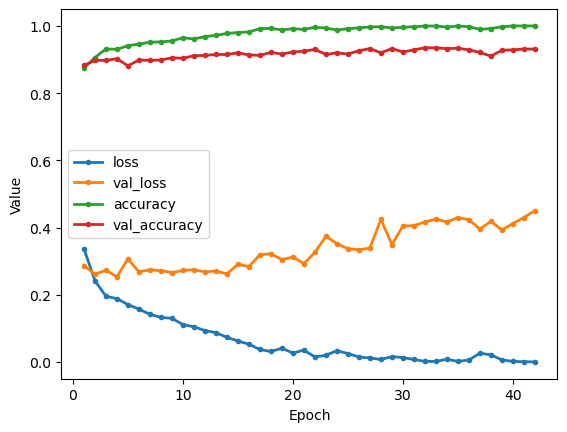

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1624,0.000000,0.0,0.004926,0.009852,0.000000,0.0,0.000000,0.0,0.000000,0.004926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4411,0.000000,0.0,0.000000,0.002809,0.000000,0.0,0.002809,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2917,0.005181,0.0,0.000000,0.000000,0.005181,0.0,0.000000,0.0,0.005181,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4581,0.000000,0.0,0.000000,0.008197,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2938,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8667)
X_test: (1000, 8667)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,219,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,262,273 (8.63 MB)

 Trainable params: 2,262,273 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 28s 583ms/step - accuracy: 0.4531 - loss: 0.6932

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4755 - loss: 0.6933   

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4864 - loss: 0.6932

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5143 - loss: 0.6930

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5323 - loss: 0.6925

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5493 - loss: 0.6915

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5677 - loss: 0.6896

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5744 - loss: 0.6886 - val_accuracy: 0.9362 - val_loss: 0.5693


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9219 - loss: 0.5640

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9250 - loss: 0.5188 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9339 - loss: 0.4826

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9373 - loss: 0.4488

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9401 - loss: 0.4176

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9421 - loss: 0.3911

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9439 - loss: 0.3682

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9442 - loss: 0.3631 - val_accuracy: 0.9500 - val_loss: 0.1267


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.0567

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9873 - loss: 0.0377 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9887 - loss: 0.0373

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9885 - loss: 0.0377

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 0.0382

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9881 - loss: 0.0388

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9880 - loss: 0.0392

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9880 - loss: 0.0392 - val_accuracy: 0.9737 - val_loss: 0.0833


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0045

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0146 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0155

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0163

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0167

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0168

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0166

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0166 - val_accuracy: 0.9737 - val_loss: 0.0839


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0040

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0051

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0059

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0060

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0060

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0060

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0060 - val_accuracy: 0.9737 - val_loss: 0.0978


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0014

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0025 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0025

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0025

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0024

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0024

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9750 - val_loss: 0.0947


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.4668e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9585e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4083e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0011    

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0013

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0014

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0015

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9712 - val_loss: 0.1070


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0011

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6632e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5783e-04 - val_accuracy: 0.9762 - val_loss: 0.0998


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0670e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9311e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6904e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9980e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1439e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1480e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0858e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0685e-04 - val_accuracy: 0.9750 - val_loss: 0.1007


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.9233e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2347e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1116e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6998e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4168e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2025e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9937e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9448e-04 - val_accuracy: 0.9737 - val_loss: 0.1044


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.5160e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0853e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3826e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5136e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5962e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6688e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7064e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7178e-04 - val_accuracy: 0.9750 - val_loss: 0.1054


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.9310e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5906e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5742e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5349e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5252e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5030e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4824e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4770e-04 - val_accuracy: 0.9750 - val_loss: 0.1085


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.9357e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7822e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5336e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4475e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4194e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4151e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3931e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3877e-04 - val_accuracy: 0.9750 - val_loss: 0.1110


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.8646e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6310e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8819e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7464e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6048e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6624e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8038e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8392e-05 - val_accuracy: 0.9750 - val_loss: 0.1127


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.0149e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0381e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5250e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4755e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5277e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4981e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5040e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5273e-05 - val_accuracy: 0.9750 - val_loss: 0.1156


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.4192e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6151e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3897e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8263e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9581e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9933e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0486e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0809e-05 - val_accuracy: 0.9750 - val_loss: 0.1177


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3906e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7135e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0461e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0653e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2833e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4347e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4902e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4933e-05 - val_accuracy: 0.9750 - val_loss: 0.1191


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.5496e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4101e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1529e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0907e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1222e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1390e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1858e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2227e-05 - val_accuracy: 0.9750 - val_loss: 0.1205



[Train Accuracy: 100.00% - Test Accuracy: 97.70%]


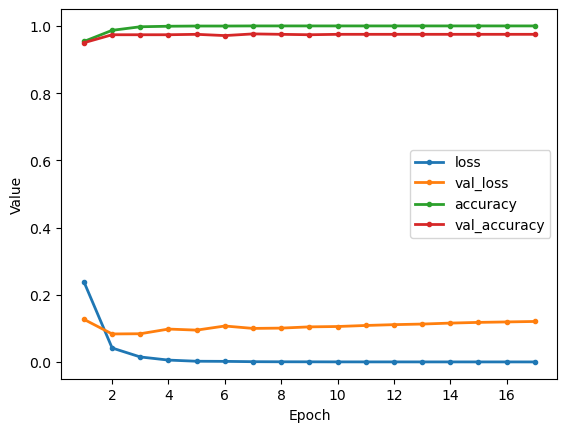

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1624,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4411,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2917,0.0,0.0,0.0,0.0,0.005208,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4581,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2938,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,928,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,969,217 (141.03 MB)

 Trainable params: 36,969,217 (141.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 39s 816ms/step - accuracy: 0.5156 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.5156 - loss: 0.6931 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5174 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5160 - loss: 0.6931

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5159 - loss: 0.6930

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.5202 - loss: 0.6930

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.5205 - loss: 0.6930

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5216 - loss: 0.6929

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5219 - loss: 0.6929

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5219 - loss: 0.6928

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5218 - loss: 0.6927

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5218 - loss: 0.6927

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5220 - loss: 0.6926

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5229 - loss: 0.6925

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5245 - loss: 0.6924

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5266 - loss: 0.6923

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5292 - loss: 0.6923

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5322 - loss: 0.6921

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5350 - loss: 0.6920

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5379 - loss: 0.6919

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5411 - loss: 0.6918

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5444 - loss: 0.6916

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5479 - loss: 0.6915

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5516 - loss: 0.6913

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5555 - loss: 0.6911

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5593 - loss: 0.6909

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5630 - loss: 0.6907

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5667 - loss: 0.6905

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5703 - loss: 0.6902

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5739 - loss: 0.6900

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5775 - loss: 0.6897

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5811 - loss: 0.6894

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5846 - loss: 0.6890

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5881 - loss: 0.6887

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5915 - loss: 0.6883

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5947 - loss: 0.6879

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5980 - loss: 0.6875

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6011 - loss: 0.6870

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6042 - loss: 0.6865

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6073 - loss: 0.6860

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6104 - loss: 0.6855

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6135 - loss: 0.6849

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6166 - loss: 0.6842

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6196 - loss: 0.6836

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6225 - loss: 0.6828

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6254 - loss: 0.6821

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6282 - loss: 0.6813

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6310 - loss: 0.6804

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6338 - loss: 0.6796

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6365 - loss: 0.6787

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.6391 - loss: 0.6778 - val_accuracy: 0.9775 - val_loss: 0.4264


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 1.0000 - loss: 0.3653

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9961 - loss: 0.3687

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9939 - loss: 0.3670

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9906 - loss: 0.3636

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9887 - loss: 0.3596

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9871 - loss: 0.3559

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9864 - loss: 0.3521

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9861 - loss: 0.3477

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9861 - loss: 0.3428

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9860 - loss: 0.3382

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9860 - loss: 0.3335

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9858 - loss: 0.3288

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9855 - loss: 0.3245

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9852 - loss: 0.3202

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9849 - loss: 0.3161

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9846 - loss: 0.3119

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9844 - loss: 0.3079

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9843 - loss: 0.3040

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9841 - loss: 0.3004

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9840 - loss: 0.2968

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9840 - loss: 0.2932

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9838 - loss: 0.2897

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9837 - loss: 0.2864

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9836 - loss: 0.2830

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9835 - loss: 0.2798

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9835 - loss: 0.2766

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9835 - loss: 0.2735

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9835 - loss: 0.2704

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9834 - loss: 0.2675

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9833 - loss: 0.2647

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9831 - loss: 0.2620

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9831 - loss: 0.2593

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9830 - loss: 0.2567

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9829 - loss: 0.2541

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9829 - loss: 0.2515

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9829 - loss: 0.2491

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9828 - loss: 0.2467

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9828 - loss: 0.2443

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9828 - loss: 0.2420

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9827 - loss: 0.2397

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9827 - loss: 0.2375

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9827 - loss: 0.2354

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2333

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2312

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2292

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2272

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2252

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2233

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2214

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9827 - loss: 0.2196

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9827 - loss: 0.2178 - val_accuracy: 0.9825 - val_loss: 0.0686


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 1.0000 - loss: 0.0212

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0178

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0158

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0147

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0138

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0131

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0125

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0120

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0116

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0113

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0110

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0107

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0105

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0103

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0101

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0099

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0097

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0095

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0094

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0093

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0091

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0090

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0089

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0088

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0087

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0086

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0085

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0084

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0083

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0083

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0082

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0081

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0080

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0080

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0079

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.0078

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.0078

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.0077

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0076

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0076

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0075

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0075

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0074

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0074

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0073

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0073

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0072

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0072

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0071

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0071

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9812 - val_loss: 0.0556


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 0.0025

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0026

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0025

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0024

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0024

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0023

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0023

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0023

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0023

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0022

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0022

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0022

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0022

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0021

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0021

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0021

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0021

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0021

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0021

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0020

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0020

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0020

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0020

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0020

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0019

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0019

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0019

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0019

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0019

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0019

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0019

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0019

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0019

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0018

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0018

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0018

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0018

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0018

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0018

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9825 - val_loss: 0.0551


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 6.8965e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 8.0431e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.4513e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.6609e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.0114e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2395e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.3229e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.3233e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.3219e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.3479e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 9.3486e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.3250e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.2821e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 9.2285e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.1737e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 9.1211e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 9.0819e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.0355e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.9868e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.9459e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.9146e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.8825e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.8529e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.8251e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.7957e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.7655e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.7385e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.7096e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6809e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6531e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6302e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6198e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6064e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5903e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5736e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5559e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5413e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5249e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5094e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.4917e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.4738e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.4559e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.4372e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.4189e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.4039e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.3886e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.3726e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.3557e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.3398e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.3233e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.3074e-04 - val_accuracy: 0.9812 - val_loss: 0.0561


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 1.0000 - loss: 4.0193e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.4676e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.7860e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.8044e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.7069e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6090e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.5683e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 4.7317e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.8430e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 4.9119e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.9636e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 4.9900e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.0132e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.0310e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.0380e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.0389e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.0682e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.0984e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 5.1288e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.1478e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1684e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1901e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 5.2051e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 5.2139e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2212e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2282e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2336e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2369e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2453e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2493e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2509e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2536e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2651e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2753e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.2855e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.2946e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3021e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3079e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3124e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3155e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3163e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.3158e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.3135e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.3103e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.3059e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.3011e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.2956e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.2916e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.2865e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.2809e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.2756e-04 - val_accuracy: 0.9812 - val_loss: 0.0579


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 2.7444e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6402e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.5046e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6032e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.9015e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.1974e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.3630e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.4587e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.5150e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.6010e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6585e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6961e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.7204e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.7380e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.7550e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.7587e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.7558e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.7539e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.7462e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.7355e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.7233e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.7122e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.6987e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.6882e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.6946e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.6971e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.6967e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6950e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6913e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6862e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6792e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6709e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6629e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6587e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6537e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6489e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6442e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6401e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6365e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6342e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6308e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6268e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6225e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6173e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6113e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.6050e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5983e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5912e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5837e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5759e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.5683e-04 - val_accuracy: 0.9812 - val_loss: 0.0592


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 1.6300e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.6712e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.6736e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.6758e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.6858e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7074e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.7552e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7812e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8054e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8188e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8285e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8311e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8347e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8325e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8295e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8288e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8261e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8261e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.8246e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8329e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8461e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8594e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8696e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8777e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8845e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8911e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.8990e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9055e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9113e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9161e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9196e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9262e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9321e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.9365e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9409e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9491e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9567e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9630e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.9686e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.9736e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9776e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.9808e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9835e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9854e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9870e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9881e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9889e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9893e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9892e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.9890e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.9888e-04 - val_accuracy: 0.9812 - val_loss: 0.0659


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.2117e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.0794e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.9701e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.9206e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.8432e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.7787e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7319e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7097e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6960e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.6828e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.6664e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.6500e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.6391e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.6263e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.6156e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.6030e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.5924e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.5815e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5709e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5689e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5666e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5660e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.5652e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5630e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5601e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.5572e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5543e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5525e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5654e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5765e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5863e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5942e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.6006e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.6071e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6128e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6175e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6212e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6242e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6262e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6278e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.6288e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.6294e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6307e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6315e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6320e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6321e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6319e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6314e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6307e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.6299e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 1.6291e-04 - val_accuracy: 0.9825 - val_loss: 0.0575


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 1.0000 - loss: 1.4359e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.2923e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.2605e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.2328e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.1956e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.1690e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.1458e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.1295e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1266e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1366e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1388e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1433e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.1450e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1438e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1427e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1397e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.1352e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.1313e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.1265e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1209e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1150e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1102e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1053e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1100e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1138e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1172e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.1197e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1214e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1223e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1228e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1237e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1238e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1236e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1241e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1244e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1242e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1239e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1237e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1240e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.1243e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1242e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1238e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1231e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1225e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.1215e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1203e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1190e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1175e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1159e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1187e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.1213e-04 - val_accuracy: 0.9812 - val_loss: 0.0633


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 9.0185e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 9.7619e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 9.8712e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 9.9187e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 9.7546e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.8039e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 9.7710e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.6954e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 9.5825e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.5495e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.5018e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.4450e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 9.3719e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.3070e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.2815e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.2822e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.2650e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.2717e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 9.2635e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.2480e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.2335e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.2166e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.1937e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.1670e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.1374e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.1250e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 9.1117e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0951e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0757e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0579e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0421e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0655e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.0855e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 9.1006e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1122e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1189e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1226e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1226e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1213e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1195e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1156e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.1114e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.1042e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0945e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0844e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0737e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0607e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0492e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0365e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 9.0226e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 9.0093e-05 - val_accuracy: 0.9812 - val_loss: 0.0678


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 3.6379e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 6.5395e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.8791e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 6.9092e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 6.7137e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.5146e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.3579e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.2174e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.0996e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.0254e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.9657e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.9397e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.9135e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8876e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8612e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8488e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8321e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.8091e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.7829e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7626e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7559e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7472e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7639e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7848e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.8009e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.8155e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.8260e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8307e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8367e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8388e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8392e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8369e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8316e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.8248e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.8194e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.8124e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.8031e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7978e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7909e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7821e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7876e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7911e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.7944e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 5.7988e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8015e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8029e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8034e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8019e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8003e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.8009e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 5.8015e-05 - val_accuracy: 0.9812 - val_loss: 0.0746



[Train Accuracy: 100.00% - Test Accuracy: 97.60%]


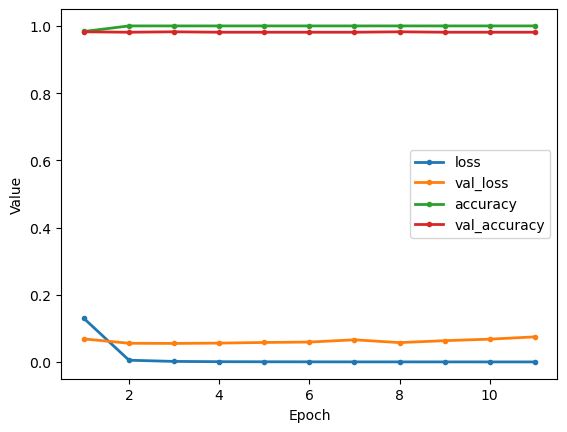

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/C2H2/report_QPSD40C5.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################